In [4]:
from gssl_func import *
import gssl_func
from sklearn.neighbors import kneighbors_graph
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)

In [ ]:
gssl_func.unknown_label = -1
label_percents = [0.3, 0.5]
gssl_func.epsilon = 10
lam = 1
USE_CORA = False

In [2]:
x, labels = mnist_dataset()

train_labels, train_index, test_labels, test_index = sample_test_train_indices(labels, 0.1)
index_path = 'dataset/index_mnist.pkl'
(train_labels, train_index, test_labels, test_index) = pkl.load(open(index_path, 'rb'))
y_part_sklearn = np.array([labels[i] if i in train_index else -1 for i in range(x.shape[0])])

In [3]:
x.shape

(2000, 960)

In [4]:
w = opt_L_given_Y(x)

Constructing graph from features
Solution found after 444 iterations:
    objective function f(sol) = 2.052550e+03
    stopping criterion: RTOL


In [5]:
rbf_w = rbf_kernel(x)
knn_w = np.array(kneighbors_graph(x, 10, mode='distance').todense())

for i in range(knn_w.shape[0]):
    for j in range(i+1, knn_w.shape[0]):
        knn_w[i][j] = max(knn_w[i][j], knn_w[j][i])
        knn_w[j][i] = knn_w[i][j]
write_edgelist(knn_w, 'mnist')

In [ ]:
total_ind = np.array([i for i in range(labels.shape[0])])
label_frac = [10,0.01,0.05,0.1,0.2]
it = 0
for frac in label_frac:
    for t in range(5):
        if frac==10:
            temp = []
            for i in range(1, frac+1):
                temp = temp + sample(list(np.where(labels==i)[0]), 1)
            train_index = temp
            test_index = np.array(list(set(total_ind)-set(train_index)))
            train_index = np.array(train_index)
            print(train_index, test_index)
        else:
            train_labels, train_index, test_labels, test_index = sample_test_train_indices(labels, frac)
        clf = SVC()
        clf.fit(x[train_index], labels[train_index])
        acc_lists[6].append(clf.score(x[test_index], labels[test_index]))
        
        vote = []
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = biased_assimilation(w, cur_labels, train_index, test_index, reg=False, tol=0.01)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[0].append(np.average(temp_it))
        
        temp_vote = []
        for i in range(1, 11):
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys = spielman_voltage(cur_labels, train_index, test_index, 'mnist', i, reg=False)
            temp_vote.append((ys))
        vote.append(np.array(temp_vote))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = johnsen(w, cur_labels, train_index, test_index, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[2].append(np.average(temp_it))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = label_prop(knn_w, cur_labels, train_index, test_index, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[3].append(np.average(temp_it))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = iterate_hebbian(w, cur_labels, train_index, test_index, eta=0.2, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[4].append(np.average(temp_it))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = edit_biased_assimilation(w, cur_labels, train_index, test_index, eta=0.2, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[5].append(np.average(temp_it))
        it += 1
        
        for j in range(6):
            cgssl_pred = (np.argmax(vote[j], axis=0)+1).reshape(-1)
            y_part_sklearn = np.array([labels[i] if i in train_index else -1 for i in range(x.shape[0])])
            acc_lists[j].append(accuracy(cgssl_pred, labels, y_part_sklearn, False))
            abs_lists[j].append((np.average(np.absolute(vote[j]))))


In [27]:
it = 0
label_frac = [10,0.01,0.05,0.1,0.2]
for frac in label_frac:
    left = it*5
    right = (1+it)*5
    print('method name\t\t average accuracy\t average abs value')
    print('Biased Assimilation:\t', np.average(acc_lists[0][left:right]), np.average(abs_lists[0][left:right]), np.average(it_lists[0][left:right]))
    print('spielmans voltage:\t', np.average(acc_lists[1][left:right]), np.average(abs_lists[1][left:right]))
    print('Friedkin-johnsen:\t', np.average(acc_lists[2][left:right]), np.average(abs_lists[2][left:right]), np.average(it_lists[2][left:right]))
    print('Label Propagation:\t', np.average(acc_lists[3][left:right]), np.average(abs_lists[3][left:right]), np.average(it_lists[3][left:right]))
    print('Iterative Hebbian:\t', np.average(acc_lists[4][left:right]), np.average(abs_lists[4][left:right]), np.average(it_lists[4][left:right]))
    print('Hebbian + Biased:\t', np.average(acc_lists[5][left:right]), np.average(abs_lists[5][left:right]), np.average(it_lists[5][left:right]))
    print('SVM:\t\t\t', np.average(acc_lists[6][left:right]))
    it += 1

method name		 average accuracy	 average abs value
Biased Assimilation:	 0.33869346733668343 0.9999767027742467 48.56666666666666
spielmans voltage:	 0.5716917922948074 0.43906497299111685
Friedkin-johnsen:	 0.523785594639866 0.004953645035629558 6.666666666666667
Label Propagation:	 0.42864321608040196 0.7861575618450298 1000.0
Iterative Hebbian:	 0.5715242881072027 0.9844976446429268 1000.0
Hebbian + Biased:	 0.5130653266331658 0.9999929851117079 39.53333333333333
SVM:			 0.48710217755443885
method name		 average accuracy	 average abs value
Biased Assimilation:	 0.3781144781144781 0.9999748748216591 49.199999999999996
spielmans voltage:	 0.5563973063973063 0.5322163225039139
Friedkin-johnsen:	 0.5574074074074075 0.010055878399562387 7.0
Label Propagation:	 0.3966329966329966 0.8016719333527548 929.1
Iterative Hebbian:	 0.5558922558922559 0.9989556076906337 983.5
Hebbian + Biased:	 0.5193602693602694 0.9999926901953544 38.86666666666667
SVM:			 0.09865319865319866
method name		 average

In [28]:
it = 0
legends = ['Friedkin-johnsen', 'BOF','Label Propagation', 'ITP', 'ITP++','Lex', 'SVM']
acc_plt = [[] for i in range(8)]
abs_plt = [[] for i in range(8)]
it_plt = [[] for i in range(8)]
for frac in label_frac:
    left = it*3
    right = (1+it)*3
    
#     print('Friedkin-johnsen:\t', np.average(acc_lists[1][left:right]), np.average(abs_lists[1][left:right]), np.average(it_lists[1][left:right]))
    acc_plt[0].append(np.average(acc_lists[2][left:right]))
    abs_plt[0].append(np.average(abs_lists[2][left:right]))
    it_plt[0].append(np.average(it_lists[2][left:right]))
    
#     print('Biased Assimilation:\t', np.average(acc_lists[4][left:right]), np.average(abs_lists[4][left:right]), np.average(it_lists[4][left:right]))
    acc_plt[1].append(np.average(acc_lists[0][left:right]))
    abs_plt[1].append(np.average(abs_lists[0][left:right]))
    it_plt[1].append(np.average(it_lists[0][left:right]))
    
#     print('Label Propagation:\t', np.average(acc_lists[2][left:right]), np.average(abs_lists[2][left:right]), np.average(it_lists[2][left:right]))
    acc_plt[2].append(np.average(acc_lists[3][left:right]))
    abs_plt[2].append(np.average(abs_lists[3][left:right]))
    it_plt[2].append(np.average(it_lists[3][left:right]))
    
#     print('Iterative Hebbian:\t', np.average(acc_lists[3][left:right]), np.average(abs_lists[3][left:right]), np.average(it_lists[3][left:right]))
    acc_plt[3].append(np.average(acc_lists[4][left:right]))
    abs_plt[3].append(np.average(abs_lists[4][left:right]))
    it_plt[3].append(np.average(it_lists[4][left:right]))
    
    acc_plt[4].append(np.average(acc_lists[5][left:right]))
    abs_plt[4].append(np.average(abs_lists[5][left:right]))
    it_plt[4].append(np.average(it_lists[5][left:right]))
    
#     print('method name\t\t average accuracy\t average abs value')
#     print('spielmans voltage:\t', np.average(acc_lists[0][left:right]), np.average(abs_lists[0][left:right]), np.average(it_lists[0][left:right]))
    acc_plt[5].append(np.average(acc_lists[1][left:right]))
    abs_plt[5].append(np.average(abs_lists[1][left:right]))
    
#     print('SVM:\t\t\t', np.average(acc_lists[5][left:right]))
    acc_plt[6].append(np.average(acc_lists[6][left:right]))
    
    it += 1

In [2]:
file = open('results/mnist.pkl', 'rb')
result_dict = pkl.load(file)
# {'accuracy':acc_plt, 'methods':legends, 'iteration': it_plt, 'abs':abs_plt, 'label_ratio':label_frac}
acc_plt = result_dict['accuracy']
legends = ['Friedkin-johnsen', 'BOF','Label Propagation', 'ITP', 'ITP++','Lex', 'SVM']
it_plt = result_dict['iteration']
abs_plt = result_dict['abs']
label_frac = result_dict['label_ratio']

In [21]:
acc_plt[5]

[0.45025125628140705,
 0.09696969696969697,
 0.09842105263157895,
 0.09555555555555556,
 0.09375]

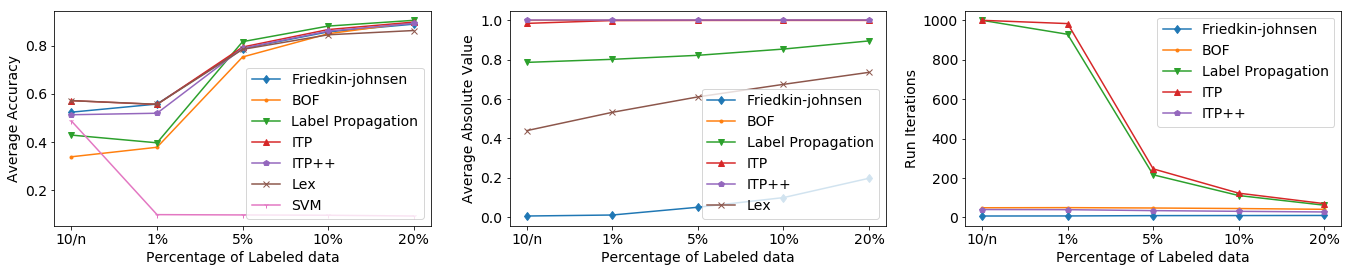

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(19,4))
# legends = ['Friedkin-johnsen', 'BOF','Label Propagation', 'ITP', 'ITP++','Lex', 'SVM']
markers = ['d','.','v','^','p','x','1']
for i in range(7):
    axs[0].plot(acc_plt[i], label=legends[i], marker=markers[i])
axs[0].legend()
# plt.title('Digits Dataset Accuracy')
axs[0].set_xlabel('Percentage of Labeled data')
axs[0].set_ylabel('Average Accuracy')
axs[0].set_xticklabels(['','10/n','1%','5%','10%','20%'])

for i in range(6):
    axs[1].plot(abs_plt[i], label=legends[i], marker=markers[i])
axs[1].legend()
# plt.title('Digits Dataset Accuracy')
axs[1].set_xlabel('Percentage of Labeled data')
axs[1].set_ylabel('Average Absolute Value')
axs[1].set_xticklabels(['','10/n','1%','5%','10%','20%'])

for i in range(5):
    axs[2].plot(it_plt[i], label=legends[i], marker=markers[i])
axs[2].legend()
# plt.title('Digits Dataset Accuracy')
axs[2].set_xlabel('Percentage of Labeled data')
axs[2].set_ylabel('Run Iterations')
axs[2].set_xticklabels(['','10/n','1%','5%','10%','20%'])
plt.tight_layout()
plt.savefig('plt/classification/mnist_all.png')
plt.show()

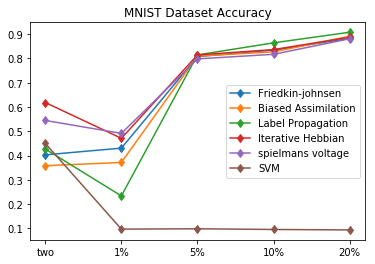

In [26]:

for i in range(6):
    plt.plot(acc_plt[i], label=legends[i], marker='d')
plt.legend()
plt.title('MNIST Dataset Accuracy')
plt.xticks([0,1,2,3,4],['*','1%','5%','10%','20%'])
plt.show()

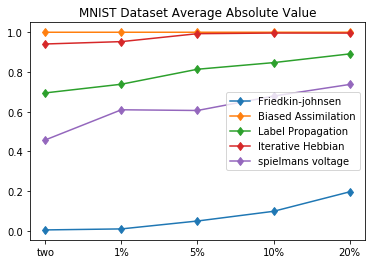

In [27]:

for i in range(5):
    plt.plot(abs_plt[i], label=legends[i], marker='d')
plt.legend()
plt.title('MNIST Dataset Average Absolute Value')
plt.xticks([0,1,2,3,4],['*','1%','5%','10%','20%'])
plt.show()

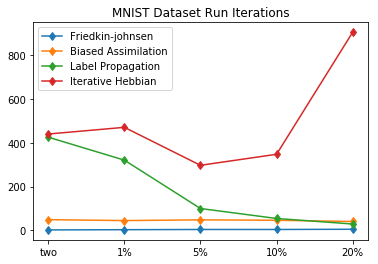

In [28]:

for i in range(4):
    plt.plot(it_plt[i], label=legends[i], marker='d')
plt.legend()
plt.title('MNIST Dataset Run Iterations')
plt.xticks([0,1,2,3,4],['*','1%','5%','10%','20%'])
plt.show()

In [19]:
result_pkl_path = 'results/mnist.pkl'
methods = ['Spielmans\' voltage', 'Friedkin-johnsen', 'Label Propagation', 'Iterative Hebbian','Biased Assimilation', 'SVM', 'Iterative Hebbian2', 'Iterative Hebbian3']
result_dict = {'accuracy':acc_plt, 'methods':legends, 'iteration': it_plt, 'abs':abs_plt, 'label_ratio':label_frac}
pkl.dump(result_dict, open( result_pkl_path, "wb" ))

In [12]:
vote[3].shape

(10, 2000)

In [11]:

vote = []
for i in range(1, 11):
    cur_labels = np.array([1 if label==i else 2 for label in labels])
    y_part_sklearn = np.array([cur_labels[i] if i in train_index else -1 for i in range(x.shape[0])])
#     print('\ncgssl')
    up_bound = 2.5
    low_bound = 0.5
#     _acc, _err, ys = iterate_optimize(x, cur_labels, train_index, test_index, max_it=5, lam=1, alpha=1, beta=1,
#                      low_bound=-1, up_bound=1, reg=False)
    ys = cgssl(x, cur_labels, y_part_sklearn, w, up_bound, low_bound)
    vote.append((ys))
opt_vote = np.array(vote)

Optimizing labels based on graph

The optimal value is 1.4819528490738936
[[ 157   28]
 [   4 1627]]
current accuracy: 0.9823788546255506
Constructing graph from features
Solution found after 449 iterations:
    objective function f(sol) = 2.053930e+03
    stopping criterion: RTOL
Optimizing labels based on graph

The optimal value is 0.37832051955522594
[[ 158   27]
 [   4 1627]]
current accuracy: 0.9829295154185022
Optimizing labels based on graph

The optimal value is 1.7682591935121
[[ 179    4]
 [   6 1627]]
current accuracy: 0.9944933920704846
Constructing graph from features
Solution found after 445 iterations:
    objective function f(sol) = 2.054552e+03
    stopping criterion: RTOL
Optimizing labels based on graph

The optimal value is 0.5011820612724271
[[ 180    3]
 [   6 1627]]
current accuracy: 0.9950440528634361
Optimizing labels based on graph

The optimal value is 3.2906981139041354
[[ 111   75]
 [   4 1626]]
current accuracy: 0.9564977973568282
Constructing graph from 

In [15]:
cgssl_pred = np.argmin(opt_vote, axis=0)+1
y_part_sklearn = np.array([labels[i] if i in train_index else -1 for i in range(x.shape[0])])
print('Accuracy is', accuracy(cgssl_pred, labels, y_part_sklearn, True))
print(np.average(np.absolute(opt_vote-1.5),axis=1))

[[171   0   0   0   1   0  13   0   0   0]
 [  0 180   0   0   2   0   0   0   1   0]
 [  0   0 165  10   0   0   0   3   7   1]
 [  0   0   6 163   1   4   0   0   4   4]
 [  0   6   1   0 159   0   4   2   0  10]
 [  0   0   0   5   0 169   2   0   3   1]
 [  0   0   0   0   1   1 180   0   0   0]
 [  0   4   2   0   3   0   0 128   0  46]
 [  3   1   2  12   0   9   1   1 149   1]
 [  3   0   2   5   5   0   0   3   1 155]]
Accuracy is 0.8915198237885462
[0.48575282 0.49097903 0.45733963 0.44307428 0.47097124 0.4602442
 0.47963657 0.46471921 0.46192853 0.45589016]


In [23]:
def biased_assimilation(adj_mat, labels, train_index, test_index, max_it=10, b=1, reg=True):
    temp_label = np.array(labels)
    temp_label = (temp_label + 1) / 2
    self_weight = np.array([0 if i in train_index else 1 for i in range(labels.shape[0])])
    previous_x = np.array([temp_label[i] if i in train_index else 0.5 for i in range(labels.shape[0])])

    it = 0
    while it < max_it:
        s = np.matmul(previous_x, normalized(adj_mat))
        s[np.where(s == 0)] += 0.0001
        s[np.where(s == 1)] -= 0.0001
        cur_x = []
        for i in range(labels.shape[0]):
            nom = self_weight[i] * previous_x[i] + previous_x[i] ** b * s[i]
            deno = self_weight[i] + previous_x[i] ** b * s[i] + (1 - previous_x[i]) ** b * (1 - s[i])
            cur_x.append(nom / deno)
        previous_x = np.array(cur_x)
        it += 1
    y_pred = (previous_x - 0.5) * 2
    cla_acc, reg_err = result_metrics(labels, y_pred, test_index, reg)
    return cla_acc, reg_err, y_pred

Test a different graph construction objective.

In [13]:
W = lg.l2_degree_reg(x)

In [14]:
adj_mat = sp.csr_matrix(matrix_from_weights(W, x.shape[0], False))
hmn = HMN(adj_mat)
hmn.fit(train_index, train_labels)
y_pred = hmn.predict(test_index)


print('first round accuracy', accuracy_score(test_labels, y_pred))

first round accuracy 0.9201710620099787


In [4]:

def gradent(w, y_part_sklearn, low_bound, up_bound):
    epsilon = 0.01
    alpha = 0.1
    ite = 0
    L = matrix_from_weights(w,y_part_sklearn.shape[0])
    mean = (up_bound+low_bound)/2
    pre_y = y = np.array([i if i!=-1 else mean for i in y_part_sklearn])
    
    fixed_index = list(np.argwhere(y_part_sklearn!=-1).reshape(-1))
#     f_prev = np.matmul(np.matmul(y.T,L),y)
    while ite<1000:
        g = 2 * np.matmul(L,y).reshape(-1)
        g = np.array([0 if i in fixed_index else g[i] for i in range(g.shape[0])])
#         print(np.argwhere(g>0))
        y = pre_y - g * alpha
        for i in range(y.shape[0]):
            if y[i]<low_bound:
                y[i]=low_bound
                fixed_index.append(i)
            if y[i]> up_bound:
                y[i]=up_bound
                fixed_index.append(i)
#         f = np.matmul(np.matmul(y.T,L),y)
#         if abs(f-f_prev)<epsilon:
        if np.linalg.norm(pre_y-y)<epsilon:
            print('optimal found')
            break
        pre_y = y
        ite += 1
    return y

def cgssl2(x, labels, y_part_sklearn, w, up_bound, low_bound):
    previous_y = y_part_sklearn
    cur_y = opt_Y_given_L(w, y_part_sklearn, low_bound, up_bound)
    acc = accuracy(cur_y, labels, y_part_sklearn)
    print('current accuracy:', acc)

    while np.linalg.norm(previous_y - cur_y) >= 8:
        w = opt_L_given_Y(x, cur_y)
        previous_y = cur_y
        cur_y = gradent(w, y_part_sklearn, low_bound, up_bound)
        print('current accuracy:', accuracy(cur_y, labels, y_part_sklearn))
    # accuracy(cur_y, labels, y_part_sklearn, True)
    return cur_y

def multi_class_cgssl2(x, labels, train_index, class_range):
    w = opt_L_given_Y(x)
    vote = []
    for i in range(1, class_range + 1):
        print('round', i)
        cur_labels = [1 if label == i else 2 for label in labels]
        y_part_sklearn = np.array([cur_labels[i] if i in train_index else -1 for i in range(x.shape[0])])
        #     print('\ncgssl')
        up_bound = 2
        low_bound = 1
        ys = cgssl2(x, cur_labels, y_part_sklearn, w, up_bound, low_bound)
        vote.append(abs(ys - 1))
    vote = np.array(vote)
    cgssl_pred = np.argmin(vote, axis=0) + 1
    y_part_sklearn = np.array([labels[i] if i in train_index else -1 for i in range(x.shape[0])])
    print('Accuracy is', accuracy(cgssl_pred, labels, y_part_sklearn, True))
    return cgssl_pred, y_part_sklearn



In [4]:

multi_class_cgssl2(x, labels, train_index, 10)

Constructing graph from features
Solution found after 444 iterations:
    objective function f(sol) = 2.052550e+03
    stopping criterion: RTOL
round 1
Optimizing labels based on graph

The optimal value is 2.491479031907107
current accuracy: 0.9950980392156863
Constructing graph from features
Solution found after 448 iterations:
    objective function f(sol) = 2.054315e+03
    stopping criterion: RTOL
optimal found
current accuracy: 0.9950980392156863
round 2
Optimizing labels based on graph

The optimal value is 3.9922916957481496
current accuracy: 0.9950980392156863
Constructing graph from features
Solution found after 445 iterations:
    objective function f(sol) = 2.055071e+03
    stopping criterion: RTOL
optimal found
current accuracy: 0.9950980392156863
round 3
Optimizing labels based on graph

The optimal value is 6.1745002653744105
current accuracy: 0.9866946778711485
Constructing graph from features
Solution found after 432 iterations:
    objective function f(sol) = 2.057655

(array([ 1,  1,  1, ..., 10, 10, 10]), array([-1, -1,  1, ..., -1, -1, 10]))

In [12]:
# write_edgelist(knn_w, 'mnist')
acc_lists = [[] for i in range(8)]
abs_lists = [[] for i in range(8)]
it_lists = [[] for i in range(8)]
total_ind = np.array([i for i in range(labels.shape[0])])
label_frac = [1, 2, 4, 8]
it = 0
for frac in label_frac:
    for t in range(3):
        temp = []
        for i in range(1, 11):
            temp = temp + sample(list(np.where(labels==i)[0]), 1)
        
        test_index = list(set(total_ind)-set(temp))
        temp = temp + sample(test_index, frac*10-10)
        test_index = np.array(list(set(total_ind)-set(temp)))
        train_index = np.array(temp)
        print(train_index.shape, test_index.shape)
#         else:
#         _train_labels, train_index2, _test_labels, test_index2 = sample_test_train_indices(labels, frac)
        clf = SVC()
        clf.fit(x[train_index], labels[train_index])
        acc_lists[6].append(clf.score(x[test_index], labels[test_index]))
        
        vote = []
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = biased_assimilation(w, cur_labels, train_index, test_index, reg=False, tol=0.01)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[0].append(np.average(temp_it))
        
        temp_vote = []
        for i in range(1, 11):
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys = spielman_voltage(cur_labels, train_index, test_index, 'mnist', i, reg=False)
            temp_vote.append((ys))
        vote.append(np.array(temp_vote))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = johnsen(w, cur_labels, train_index, test_index, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[2].append(np.average(temp_it))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = label_prop(knn_w, cur_labels, train_index, test_index, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[3].append(np.average(temp_it))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = iterate_hebbian(w, cur_labels, train_index, test_index, eta=0.5, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[4].append(np.average(temp_it))
        
        temp_vote = []
        temp_it = []
        for i in range(1, 11):
            
            cur_labels = np.array([1 if label==i else -1 for label in labels])
            _acc, _err, ys, it = edit_biased_assimilation(w, cur_labels, train_index, test_index, eta=0.5, reg=False)
            temp_vote.append((ys))
            temp_it.append(it)
        vote.append(np.array(temp_vote))
        it_lists[5].append(np.average(temp_it))
        it += 1
        
        for j in range(6):
            cgssl_pred = (np.argmax(vote[j], axis=0)+1).reshape(-1)
            y_part_sklearn = np.array([labels[i] if i in train_index else -1 for i in range(x.shape[0])])
            acc_lists[j].append(accuracy(cgssl_pred, labels, y_part_sklearn, False))
            abs_lists[j].append((np.average(np.absolute(vote[j]))))
#     break

(10,) (1990,)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9110552763819095 1813.0 1990.0
classification accuracy 0.9311557788944723 1853.0 1990.0
classification accuracy 0.885929648241206 1763.0 1990.0
classification accuracy 0.9020100502512562 1795.0 1990.0
classification accuracy 0.9035175879396985 1798.0 1990.0
classification accuracy 0.9266331658291457 1844.0 1990.0
classification accuracy 0.9130653266331659 1817.0 1990.0
classification accuracy 0.9201005025125628 1831.0 1990.0
classification accuracy 0.8979899497487437 1787.0 1990.0
classification accuracy 0.9180904522613065 1827.0 1990.0
classification accuracy 0.8974874371859296 1786.0 1990.0
classification accuracy 0.9552763819095478 1901.0 1990.0
classification accuracy 0.9055276381909547 1802.0 1990.0
classification accuracy 0.8603015075376884 1712.0 1990.0
classification accuracy 0.8964824120603015 1784.0 1990.0
classification accuracy 0.950251256281407 1891.0 1990.0
classification accuracy 0.9306532663316583 1852.0 1990.0
classification accuracy 0.9587939

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9261306532663317 1843.0 1990.0
classification accuracy 0.9457286432160804 1882.0 1990.0
classification accuracy 0.9040201005025126 1799.0 1990.0
classification accuracy 0.9035175879396985 1798.0 1990.0
classification accuracy 0.9095477386934674 1810.0 1990.0
classification accuracy 0.907035175879397 1805.0 1990.0
classification accuracy 0.9331658291457287 1857.0 1990.0
classification accuracy 0.9105527638190954 1812.0 1990.0
classification accuracy 0.9110552763819095 1813.0 1990.0
classification accuracy 0.8864321608040201 1764.0 1990.0
classification accuracy 0.9698492462311558 1930.0 1990.0
classification accuracy 0.9477386934673366 1886.0 1990.0
classification accuracy 0.9221105527638191 1835.0 1990.0
classification accuracy 0.8944723618090452 1780.0 1990.0
classification accuracy 0.9281407035175879 1847.0 1990.0
classification accuracy 0.9241206030150754 1839.0 1990.0
classification accuracy 0.9407035175879397 1872.0 1990.0
classification accuracy 0.915075

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9331658291457287 1857.0 1990.0
classification accuracy 0.9402010050251256 1871.0 1990.0
classification accuracy 0.8939698492462311 1779.0 1990.0
classification accuracy 0.9150753768844221 1821.0 1990.0
classification accuracy 0.9015075376884422 1794.0 1990.0
classification accuracy 0.907035175879397 1805.0 1990.0
classification accuracy 0.907537688442211 1806.0 1990.0
classification accuracy 0.9165829145728643 1824.0 1990.0
classification accuracy 0.9165829145728643 1824.0 1990.0
classification accuracy 0.9120603015075377 1815.0 1990.0
classification accuracy 0.9683417085427136 1927.0 1990.0
classification accuracy 0.9688442211055276 1928.0 1990.0
classification accuracy 0.8291457286432161 1650.0 1990.0
classification accuracy 0.8688442211055276 1729.0 1990.0
classification accuracy 0.9160804020100503 1823.0 1990.0
classification accuracy 0.9150753768844221 1821.0 1990.0
classification accuracy 0.8864321608040201 1764.0 1990.0
classification accuracy 0.9412060

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9222222222222223 1826.0 1980.0
classification accuracy 0.8883838383838384 1759.0 1980.0
classification accuracy 0.9378787878787879 1857.0 1980.0
classification accuracy 0.9378787878787879 1857.0 1980.0
classification accuracy 0.8858585858585859 1754.0 1980.0
classification accuracy 0.9202020202020202 1822.0 1980.0
classification accuracy 0.9383838383838384 1858.0 1980.0
classification accuracy 0.8893939393939394 1761.0 1980.0
classification accuracy 0.9141414141414141 1810.0 1980.0
classification accuracy 0.9196969696969697 1821.0 1980.0
classification accuracy 0.9494949494949495 1880.0 1980.0
classification accuracy 0.952020202020202 1885.0 1980.0
classification accuracy 0.9575757575757575 1896.0 1980.0
classification accuracy 0.9434343434343434 1868.0 1980.0
classification accuracy 0.8691919191919192 1721.0 1980.0
classification accuracy 0.9343434343434344 1850.0 1980.0
classification accuracy 0.9606060606060606 1902.0 1980.0
classification accuracy 0.878787

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.956060606060606 1893.0 1980.0
classification accuracy 0.9565656565656566 1894.0 1980.0
classification accuracy 0.9181818181818182 1818.0 1980.0
classification accuracy 0.8974747474747474 1777.0 1980.0
classification accuracy 0.9171717171717172 1816.0 1980.0
classification accuracy 0.9196969696969697 1821.0 1980.0
classification accuracy 0.9308080808080809 1843.0 1980.0
classification accuracy 0.9116161616161617 1805.0 1980.0
classification accuracy 0.9292929292929293 1840.0 1980.0
classification accuracy 0.8924242424242425 1767.0 1980.0
classification accuracy 0.9641414141414142 1909.0 1980.0
classification accuracy 0.9848484848484849 1950.0 1980.0
classification accuracy 0.9292929292929293 1840.0 1980.0
classification accuracy 0.8924242424242425 1767.0 1980.0
classification accuracy 0.9111111111111111 1804.0 1980.0
classification accuracy 0.9166666666666666 1815.0 1980.0
classification accuracy 0.9328282828282828 1847.0 1980.0
classification accuracy 0.919191

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9247474747474748 1831.0 1980.0
classification accuracy 0.9398989898989899 1861.0 1980.0
classification accuracy 0.9202020202020202 1822.0 1980.0
classification accuracy 0.9111111111111111 1804.0 1980.0
classification accuracy 0.9257575757575758 1833.0 1980.0
classification accuracy 0.943939393939394 1869.0 1980.0
classification accuracy 0.9156565656565656 1813.0 1980.0
classification accuracy 0.8868686868686869 1756.0 1980.0
classification accuracy 0.9217171717171717 1825.0 1980.0
classification accuracy 0.9222222222222223 1826.0 1980.0
classification accuracy 0.9712121212121212 1923.0 1980.0
classification accuracy 0.9757575757575757 1932.0 1980.0
classification accuracy 0.9626262626262626 1906.0 1980.0
classification accuracy 0.9267676767676768 1835.0 1980.0
classification accuracy 0.9095959595959596 1801.0 1980.0
classification accuracy 0.9353535353535354 1852.0 1980.0
classification accuracy 0.9191919191919192 1820.0 1980.0
classification accuracy 0.887373

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9872448979591837 1935.0 1960.0
classification accuracy 0.951530612244898 1865.0 1960.0
classification accuracy 0.9132653061224489 1790.0 1960.0
classification accuracy 0.951530612244898 1865.0 1960.0
classification accuracy 0.9331632653061225 1829.0 1960.0
classification accuracy 0.9336734693877551 1830.0 1960.0
classification accuracy 0.95 1862.0 1960.0
classification accuracy 0.9188775510204081 1801.0 1960.0
classification accuracy 0.9346938775510204 1832.0 1960.0
classification accuracy 0.9270408163265306 1817.0 1960.0
classification accuracy 0.9846938775510204 1930.0 1960.0
classification accuracy 0.976530612244898 1914.0 1960.0
classification accuracy 0.9596938775510204 1881.0 1960.0
classification accuracy 0.939795918367347 1842.0 1960.0
classification accuracy 0.9443877551020409 1851.0 1960.0
classification accuracy 0.9377551020408164 1838.0 1960.0
classification accuracy 0.9607142857142857 1883.0 1960.0
classification accuracy 0.9306122448979591 1824.0

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9846938775510204 1930.0 1960.0
classification accuracy 0.9556122448979592 1873.0 1960.0
classification accuracy 0.9127551020408163 1789.0 1960.0
classification accuracy 0.9489795918367347 1860.0 1960.0
classification accuracy 0.9510204081632653 1864.0 1960.0
classification accuracy 0.9306122448979591 1824.0 1960.0
classification accuracy 0.938265306122449 1839.0 1960.0
classification accuracy 0.9193877551020408 1802.0 1960.0
classification accuracy 0.9392857142857143 1841.0 1960.0
classification accuracy 0.9260204081632653 1815.0 1960.0
classification accuracy 0.9729591836734693 1907.0 1960.0
classification accuracy 0.9770408163265306 1915.0 1960.0
classification accuracy 0.9183673469387755 1800.0 1960.0
classification accuracy 0.9219387755102041 1807.0 1960.0
classification accuracy 0.9295918367346939 1822.0 1960.0
classification accuracy 0.9454081632653061 1853.0 1960.0
classification accuracy 0.9433673469387756 1849.0 1960.0
classification accuracy 0.952551

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9678571428571429 1897.0 1960.0
classification accuracy 0.9744897959183674 1910.0 1960.0
classification accuracy 0.9551020408163265 1872.0 1960.0
classification accuracy 0.9183673469387755 1800.0 1960.0
classification accuracy 0.95 1862.0 1960.0
classification accuracy 0.8964285714285715 1757.0 1960.0
classification accuracy 0.9239795918367347 1811.0 1960.0
classification accuracy 0.9188775510204081 1801.0 1960.0
classification accuracy 0.9219387755102041 1807.0 1960.0
classification accuracy 0.9163265306122449 1796.0 1960.0
classification accuracy 0.9801020408163266 1921.0 1960.0
classification accuracy 0.9826530612244898 1926.0 1960.0
classification accuracy 0.9739795918367347 1909.0 1960.0
classification accuracy 0.939795918367347 1842.0 1960.0
classification accuracy 0.9408163265306122 1844.0 1960.0
classification accuracy 0.8816326530612245 1728.0 1960.0
classification accuracy 0.9295918367346939 1822.0 1960.0
classification accuracy 0.9112244897959184 178

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.978125 1878.0 1920.0
classification accuracy 0.9708333333333333 1864.0 1920.0
classification accuracy 0.95 1824.0 1920.0
classification accuracy 0.9604166666666667 1844.0 1920.0
classification accuracy 0.9270833333333334 1780.0 1920.0
classification accuracy 0.9416666666666667 1808.0 1920.0
classification accuracy 0.990625 1902.0 1920.0
classification accuracy 0.9276041666666667 1781.0 1920.0
classification accuracy 0.9447916666666667 1814.0 1920.0
classification accuracy 0.91875 1764.0 1920.0
classification accuracy 0.9739583333333334 1870.0 1920.0
classification accuracy 0.971875 1866.0 1920.0
classification accuracy 0.9442708333333333 1813.0 1920.0
classification accuracy 0.9458333333333333 1816.0 1920.0
classification accuracy 0.9338541666666667 1793.0 1920.0
classification accuracy 0.9401041666666666 1805.0 1920.0
classification accuracy 0.9796875 1881.0 1920.0
classification accuracy 0.9421875 1809.0 1920.0
classification accuracy 0.9328125 1791.0 1920.0

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9723958333333333 1867.0 1920.0
classification accuracy 0.9916666666666667 1904.0 1920.0
classification accuracy 0.9354166666666667 1796.0 1920.0
classification accuracy 0.9494791666666667 1823.0 1920.0
classification accuracy 0.9380208333333333 1801.0 1920.0
classification accuracy 0.9328125 1791.0 1920.0
classification accuracy 0.9239583333333333 1774.0 1920.0
classification accuracy 0.9223958333333333 1771.0 1920.0
classification accuracy 0.9442708333333333 1813.0 1920.0
classification accuracy 0.9322916666666666 1790.0 1920.0
classification accuracy 0.9744791666666667 1871.0 1920.0
classification accuracy 0.9880208333333333 1897.0 1920.0
classification accuracy 0.9484375 1821.0 1920.0
classification accuracy 0.9354166666666667 1796.0 1920.0
classification accuracy 0.9536458333333333 1831.0 1920.0
classification accuracy 0.9380208333333333 1801.0 1920.0
classification accuracy 0.9317708333333333 1789.0 1920.0
classification accuracy 0.94375 1812.0 1920.0
cla

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classification accuracy 0.9885416666666667 1898.0 1920.0
classification accuracy 0.978125 1878.0 1920.0
classification accuracy 0.9473958333333333 1819.0 1920.0
classification accuracy 0.9494791666666667 1823.0 1920.0
classification accuracy 0.9578125 1839.0 1920.0
classification accuracy 0.975 1872.0 1920.0
classification accuracy 0.9885416666666667 1898.0 1920.0
classification accuracy 0.9473958333333333 1819.0 1920.0
classification accuracy 0.9380208333333333 1801.0 1920.0
classification accuracy 0.9098958333333333 1747.0 1920.0
classification accuracy 0.9880208333333333 1897.0 1920.0
classification accuracy 0.9765625 1875.0 1920.0
classification accuracy 0.9619791666666667 1847.0 1920.0
classification accuracy 0.95 1824.0 1920.0
classification accuracy 0.9526041666666667 1829.0 1920.0
classification accuracy 0.9677083333333333 1858.0 1920.0
classification accuracy 0.9895833333333334 1900.0 1920.0
classification accuracy 0.9463541666666667 1817.0 1920.0
classification accuracy 0.941

In [9]:
it = 0
for frac in label_frac:
    left = it*3
    right = (1+it)*3
    print('With ' + str(frac*10) + ' labeled data:')
    print('method name\t\t average accuracy\t average abs value \t iterations')
    print('Biased Assimilation:\t', np.average(acc_lists[0][left:right]), np.average(abs_lists[0][left:right]), np.average(it_lists[0][left:right]))
    print('spielmans voltage:\t', np.average(acc_lists[1][left:right]), np.average(abs_lists[1][left:right]))
    print('Friedkin-johnsen:\t', np.average(acc_lists[2][left:right]), np.average(abs_lists[2][left:right]), np.average(it_lists[2][left:right]))
    print('Label Propagation:\t', np.average(acc_lists[3][left:right]), np.average(abs_lists[3][left:right]), np.average(it_lists[3][left:right]))
    print('Biased + Hebbian1:\t', np.average(acc_lists[4][left:right]), np.average(abs_lists[4][left:right]), np.average(it_lists[4][left:right]))
    print('Biased + Hebbian2:\t', np.average(acc_lists[5][left:right]), np.average(abs_lists[5][left:right]), np.average(it_lists[5][left:right]))
#     print('Iterative Hebbian4:\t', np.average(acc_lists[7][left:right]), np.average(abs_lists[7][left:right]))
    print('SVM:\t\t\t', np.average(acc_lists[6][left:right]))
    print(' ')
    it += 1

With 10 labeled data:
method name		 average accuracy	 average abs value 	 iterations
Biased Assimilation:	 0.5787572974121198 0.9999772678704789 51.63333333333333
spielmans voltage:	 0.7140234225259606 0.5173629383659676
Friedkin-johnsen:	 0.7062545235496649 0.014905768785320891 7.666666666666667
Label Propagation:	 0.7476020783127382 0.8029516449020365 614.1333333333333
Iterative Hebbian:	 0.6986633837250226 0.9994269169330304 673.5666666666667
Biased + Hebbian:	 0.6827269989162664 0.9999923620586101 36.63333333333333
SVM:			 0.6469899537521002
 
With 20 labeled data:
method name		 average accuracy	 average abs value 	 iterations
Biased Assimilation:	 0.7763711318336513 0.9999606342050109 48.6
spielmans voltage:	 0.7472734208021595 0.5396069189187614
Friedkin-johnsen:	 0.8162777624649187 0.03872478644499597 8.333333333333334
Label Propagation:	 0.8310148945263921 0.8161398225484104 268.26666666666665
Iterative Hebbian:	 0.8188583432596047 0.9997848292570756 268.7
Biased + Hebbian:	 0.

In [15]:
X.shape

(2000, 100)